In [1]:
import re

def extract_last_values(log_file_path):
    last_values = []

    with open(log_file_path, 'r') as file:
        for line in file:
            # Match the lines containing the GPU memory usage
            match = re.search(r'python/\d+\((\d+)M\)', line[60:])
            if match:
                # Extract the memory value in MB
                memory_value = int(match.group(1))
                last_values.append(memory_value)
    
    return last_values

In [2]:
log_file_dense_matrix = 'gpu_memory_dense_matrix.log'
dense_memory = extract_last_values(log_file_dense_matrix)
print(dense_memory)

[2352, 5052, 7378, 8974, 9410, 9410]


In [3]:
dense_memory = [0] + dense_memory
dense_memory

[0, 2352, 5052, 7378, 8974, 9410, 9410]

In [4]:
log_file_sparse_matrix = 'gpu_memory_sparse_matrix.log'
sparse_memory = extract_last_values(log_file_sparse_matrix)
print(sparse_memory)

[530, 586, 598, 610, 622, 746, 934, 1172, 1280, 1456, 1718, 1722, 1730, 1784, 1784, 1784, 1784, 1784, 1784, 1784, 1784, 1784, 1784, 1784, 1784, 1784, 1784]


In [5]:
sparse_memory = [0] + sparse_memory
sparse_memory

[0,
 530,
 586,
 598,
 610,
 622,
 746,
 934,
 1172,
 1280,
 1456,
 1718,
 1722,
 1730,
 1784,
 1784,
 1784,
 1784,
 1784,
 1784,
 1784,
 1784,
 1784,
 1784,
 1784,
 1784,
 1784,
 1784]

In [6]:
max_count = max(len(sparse_memory), len(dense_memory))
if len(sparse_memory) < max_count:
    ext = (max_count - len(sparse_memory)) * [0]
    sparse_memory = sparse_memory + ext
if len(dense_memory) < max_count:
    ext = (max_count - len(dense_memory)) * [0]
    dense_memory = dense_memory + ext
sparse_memory = sparse_memory + [0]
dense_memory = dense_memory + [0]

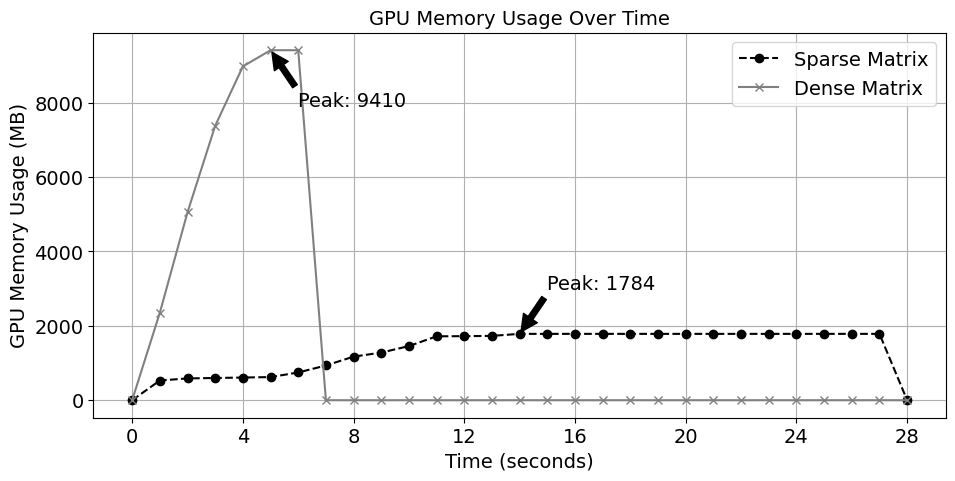

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {
    "sparse matrix": sparse_memory,
    "dense matrix": dense_memory
}
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(11, 5))
plt.plot(df.index, df["sparse matrix"], label="Sparse Matrix", marker='o', color='black', linestyle='--')
plt.plot(df.index, df["dense matrix"], label="Dense Matrix", marker='x', color='gray')

# Highlight peak value
peak_index = df["dense matrix"].idxmax()
peak_value = df["dense matrix"].max()
plt.annotate(f'Peak: {peak_value}', xy=(peak_index, peak_value), xytext=(peak_index+1, peak_value-1500),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)
peak_index = df["sparse matrix"].idxmax()
peak_value = df["sparse matrix"].max()
plt.annotate(f'Peak: {peak_value}', xy=(peak_index, peak_value), xytext=(peak_index+1, peak_value+1200),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

# Labels and title
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("GPU Memory Usage (MB)", fontsize=14)
plt.title("GPU Memory Usage Over Time", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
#plt.xticks(df.index, fontsize=12)
plt.xticks(np.arange(min(df.index), max(df.index)+1, 4.0), fontsize=14)
plt.yticks(fontsize=14)

# Save plot
plt.savefig("gpu_memory_usage.png", format='png', dpi=300)
plt.show()
